In [ ]:
import os

# Directories - change based on where your project is saved
project_dir = "/content/drive/MyDrive/Classes/Fourth/Fall/CS2822R/CS2822_Final_Project"
models_dir = os.path.join(project_dir, "Models")
datasets_dir = os.path.join(project_dir, "Datasets")
results_dir = os.path.join(project_dir, "Results")
MODEL_NAME = "resnet18.a1_in1k"

# CHANGE THESE
normal_model_name = "o2o_medium_resnet18.a1-e=2-lr=0.01_limit=20.pt"
bugged_model_name = "o2o_easy_resnet18.a1-e=2-lr=0.01_limit=20.pt"
concept_instance_name = "CRAFT_12_2_24_Corgi_Snow_320_im"

In [ ]:
# Mount google drive to local dir
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


# Experiments
- This is where we will carry out our experiment:
    - How can we detect the difference between a model with spurious correlations and a regular (non-spurious) model? Using only:
        - Concepts,
        -  their activation vectors,
        - and their importances

Below is the sekeleton of the experiment:

# Load Dependencies

In [ ]:
import argparse

import torch
import torch.optim as optim
from torch import nn
from torch.nn import Module
from torch.optim import Optimizer
from torch.utils.data import DataLoader
from torchvision import models
from tqdm import tqdm
from tqdm.auto import tqdm
import timm
import wandb
import os
import numpy as np
import matplotlib.pyplot as plt

# 0. Spawrious Source Code

In [ ]:
import os
import tarfile
import urllib
import urllib.request
from typing import Any, Tuple

import torch
from PIL import Image
from torch.utils.data import ConcatDataset, Dataset
from torchvision import transforms
from torchvision.datasets import ImageFolder
from tqdm import tqdm
import timm
from PIL import ImageFile

ImageFile.LOAD_TRUNCATED_IMAGES = True

# MODEL_NAME = "vit_so400m_patch14_siglip_384"
# MODEL_NAME = 'swin_base_patch4_window7_224.ms_in22k_ft_in1k'
# MODEL_NAME = 'deit3_base_patch16_224.fb_in22k_ft_in1k'
# MODEL_NAME = 'beit_base_patch16_224.in22k_ft_in22k_in1k'
# MODEL_NAME = 'eva02_base_patch14_448.mim_in22k_ft_in22k_in1k'
# MODEL_NAME = 'levit_128s.fb_dist_in1k'

def set_model_name(name):
    global MODEL_NAME
    MODEL_NAME = name


def _extract_dataset_from_tar(
    tar_file_name: str, data_dir: str
) -> None:
    tar_file_dst = os.path.join(data_dir, tar_file_name)
    print("Extracting dataset...")
    tar = tarfile.open(tar_file_dst, "r:gz")
    tar.extractall(os.path.dirname(tar_file_dst))
    tar.close()


def _download_dataset_if_not_available(
    dataset_name: str, data_dir: str, remove_tar_after_extracting: bool = True
) -> None:
    """
    datasets.txt file, which is present in the data_dir, is used to check if the dataset is already extracted. If the dataset is already extracted, then the tar file is not downloaded again.
    """
    data_dir = data_dir.split("/spawrious224/")[
        0
    ]  # in case people pass in the wrong root_dir
    os.makedirs(data_dir, exist_ok=True)
    dataset_name = dataset_name.lower()
    if dataset_name.split("_")[0] == "m2m":
        dataset_name = "entire_dataset"
    url_dict = {
        "entire_dataset": "https://www.dropbox.com/s/hofkueo8qvaqlp3/spawrious224__entire_dataset.tar.gz?dl=1",
        "o2o_easy": "https://www.dropbox.com/s/kwhiv60ihxe3owy/spawrious224__o2o_easy.tar.gz?dl=1",
        "o2o_medium": "https://www.dropbox.com/s/x03gkhdwar5kht4/spawrious224__o2o_medium.tar.gz?dl=1",
        "o2o_hard": "https://www.dropbox.com/s/p1ry121m2gjj158/spawrious224__o2o_hard.tar.gz?dl=1",
        # "m2m": "https://www.dropbox.com/s/5usem63nfub266y/spawrious__m2m.tar.gz?dl=1",
    }
    tar_file_name = f"spawrious224__{dataset_name}.tar.gz"
    tar_file_dst = os.path.join(data_dir, tar_file_name)
    url = url_dict[dataset_name]

    # check if the dataset is already extracted
    if _check_images_availability(data_dir, dataset_name):
        print("Dataset already downloaded and extracted.")
        return
    # check if the tar file is already downloaded
    else:
        if os.path.exists(tar_file_dst):
            print("Dataset already downloaded. Extracting...")
            _extract_dataset_from_tar(
                tar_file_name, data_dir
            )
            return
        # download the tar file and extract from it
        else:
            print("Dataset not found. Downloading...")
            response = urllib.request.urlopen(url)
            total_size = int(response.headers.get("Content-Length", 0))
            block_size = 1024
            # Track progress of download
            progress_bar = tqdm(total=total_size, unit="iB", unit_scale=True)
            with open(tar_file_dst, "wb") as f:
                while True:
                    buffer = response.read(block_size)
                    if not buffer:
                        break
                    f.write(buffer)
                    progress_bar.update(len(buffer))
            progress_bar.close()
            print("Dataset downloaded. Extracting...")
            _extract_dataset_from_tar(
                tar_file_name, data_dir
            )
            return


class CustomImageFolder(Dataset):
    """
    A class that takes one folder at a time and loads a set number of images in a folder and assigns them a specific class
    """

    def __init__(
        self, folder_path, class_index, location_index, limit=None, transform=None
    ):
        self.folder_path = folder_path
        self.class_index = class_index
        self.location_index = location_index
        self.image_paths = [
            os.path.join(folder_path, img)
            for img in os.listdir(folder_path)
            if img.endswith((".png", ".jpg", ".jpeg"))
        ]
        if limit:
            self.image_paths = self.image_paths[:limit]
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, index: int) -> Tuple[Any, Any, Any]:
        img_path = self.image_paths[index]
        img = Image.open(img_path).convert("RGB")

        if self.transform:
            img = self.transform(img)

        class_label = torch.tensor(self.class_index, dtype=torch.long)
        location_label = torch.tensor(self.location_index, dtype=torch.long)
        return img, class_label, location_label


class MultipleDomainDataset:
    N_STEPS = 5001  # Default, subclasses may override
    CHECKPOINT_FREQ = 100  # Default, subclasses may override
    N_WORKERS = 8  # Default, subclasses may override
    ENVIRONMENTS = None  # Subclasses should override
    INPUT_SHAPE = None  # Subclasses should override

    def __getitem__(self, index):
        return self.datasets[index]

    def __len__(self):
        return len(self.datasets)


def build_combination(benchmark_type, group, test, filler=None):
    total = 3168
    combinations = {}
    if "m2m" in benchmark_type:
        counts = [total, total]
        combinations["train_combinations"] = {
            ("bulldog",): [(group[0], counts[0]), (group[1], counts[1])],
            ("dachshund",): [(group[1], counts[0]), (group[0], counts[1])],
            ("labrador",): [(group[2], counts[0]), (group[3], counts[1])],
            ("corgi",): [(group[3], counts[0]), (group[2], counts[1])],
        }
        combinations["test_combinations"] = {
            ("bulldog",): [test[0], test[1]],
            ("dachshund",): [test[1], test[0]],
            ("labrador",): [test[2], test[3]],
            ("corgi",): [test[3], test[2]],
        }
    else:
        counts = [int(0.97 * total), int(0.87 * total)]
        combinations["train_combinations"] = {
            ("bulldog",): [(group[0], counts[0]), (group[0], counts[1])],
            ("dachshund",): [(group[1], counts[0]), (group[1], counts[1])],
            ("labrador",): [(group[2], counts[0]), (group[2], counts[1])],
            ("corgi",): [(group[3], counts[0]), (group[3], counts[1])],
            ("bulldog", "dachshund", "labrador", "corgi"): [
                (filler, total - counts[0]),
                (filler, total - counts[1]),
            ],
        }
        combinations["test_combinations"] = {
            ("bulldog",): [test[0], test[0]],
            ("dachshund",): [test[1], test[1]],
            ("labrador",): [test[2], test[2]],
            ("corgi",): [test[3], test[3]],
        }
    return combinations


def _get_combinations(benchmark_type: str) -> Tuple[dict, dict]:
    combinations = {
        "o2o_easy": (
            ["desert", "jungle", "dirt", "snow"],
            ["dirt", "snow", "desert", "jungle"],
            "beach",
        ),
        "o2o_medium": (
            ["mountain", "beach", "dirt", "jungle"],
            ["jungle", "dirt", "beach", "snow"],
            "desert",
        ),
        "o2o_hard": (
            ["jungle", "mountain", "snow", "desert"],
            ["mountain", "snow", "desert", "jungle"],
            "beach",
        ),
        "m2m_hard": (
            ["dirt", "jungle", "snow", "beach"],
            ["snow", "beach", "dirt", "jungle"],
            None,
        ),
        "m2m_easy": (
            ["desert", "mountain", "dirt", "jungle"],
            ["dirt", "jungle", "mountain", "desert"],
            None,
        ),
        "m2m_medium": (
            ["beach", "snow", "mountain", "desert"],
            ["desert", "mountain", "beach", "snow"],
            None,
        ),
    }
    if benchmark_type not in combinations:
        raise ValueError("Invalid benchmark type")
    group, test, filler = combinations[benchmark_type]
    return build_combination(benchmark_type, group, test, filler)


class SpawriousBenchmark(MultipleDomainDataset):
    ENVIRONMENTS = ["Test", "SC_group_1", "SC_group_2"]
    input_shape = (3, 224, 224)
    num_classes = 4
    class_list = ["bulldog", "corgi", "dachshund", "labrador"]
    locations_list = ["desert", "jungle", "dirt", "mountain", "snow", "beach"]

    def __init__(self, benchmark, root_dir, augment=True):
        combinations = _get_combinations(benchmark.lower())
        self.type1 = benchmark.lower().startswith("o2o")
        train_datasets, test_datasets = self._prepare_data_lists(
            combinations["train_combinations"],
            combinations["test_combinations"],
            root_dir,
            augment,
        )
        self.datasets = [ConcatDataset(test_datasets)] + train_datasets

    def get_train_dataset(self):
        return torch.utils.data.ConcatDataset(self.datasets[1:])

    def get_test_dataset(self):
        return self.datasets[0]

    # Prepares the train and test data lists by applying the necessary transformations.
    def _prepare_data_lists(
        self, train_combinations, test_combinations, root_dir, augment
    ):
        backbone = timm.create_model(
            # "vit_so400m_patch14_siglip_384",
            MODEL_NAME,
            pretrained=True,
            num_classes=0,
        ).eval()
        self.data_config = timm.data.resolve_model_data_config(backbone)
        test_transforms = timm.data.create_transform(
            **self.data_config, is_training=False
        )

        # test_transforms = transforms.Compose(
        #     [
        #         transforms.Resize((self.input_shape[1], self.input_shape[2])),
        #         transforms.transforms.ToTensor(),
        #         transforms.Normalize(
        #             mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
        #         ),
        #     ]
        # )

        if augment:
            train_transforms = timm.data.create_transform(
                **self.data_config, is_training=True
            )
        else:
            train_transforms = test_transforms
        print("Creating Training Dataset:")
        train_data_list = self._create_data_list(
            train_combinations, root_dir, train_transforms
        )
        print("Creating Testing Dataset:")
        test_data_list = self._create_data_list(
            test_combinations, root_dir, test_transforms
        )

        return train_data_list, test_data_list

    # Creates a list of datasets based on the given combinations and transformations.
    def _create_data_list(self, combinations, root_dir, transforms):
        data_list = []
        if isinstance(combinations, dict):
            # Build class groups for a given set of combinations, root directory, and transformations.
            for_each_class_group = []
            cg_index = 0
            for classes, comb_list in combinations.items():
                for_each_class_group.append([])
                for ind, location_limit in enumerate(comb_list):
                    if isinstance(location_limit, tuple):
                        location, limit = location_limit
                    else:
                        location, limit = location_limit, None
                    cg_data_list = []
                    for cls in classes:
                        path = os.path.join(
                            root_dir,
                            "spawrious224",
                            f"{0 if not self.type1 else ind}/{location}/{cls}",
                        )
                        print(f"    Combination: {0 if not self.type1 else ind}/{location}/{cls}")
                        print(f"    Limit: {limit}")
                        data = CustomImageFolder(
                            folder_path=path,
                            class_index=self.class_list.index(cls),
                            location_index=self.locations_list.index(location),
                            limit=limit,
                            transform=transforms,
                        )
                        cg_data_list.append(data)

                    for_each_class_group[cg_index].append(ConcatDataset(cg_data_list))
                cg_index += 1

            for group in range(len(for_each_class_group[0])):
                data_list.append(
                    ConcatDataset(
                        [
                            for_each_class_group[k][group]
                            for k in range(len(for_each_class_group))
                        ]
                    )
                )
        else:
            for location in combinations:
                path = os.path.join(root_dir, f"{0}/{location}/")
                data = ImageFolder(root=path, transform=transforms)
                data_list.append(data)

        return data_list


def _check_images_availability(root_dir: str, dataset_type: str) -> bool:
    # Get the combinations for the given dataset type
    root_dir = root_dir.split("/spawrious224/")[
        0
    ]  # in case people pass in the wrong root_dir
    if dataset_type == "entire_dataset":
        for dataset in ["0", "1", "domain_adaptation_ds"]:
            for location in ["snow", "jungle", "desert", "dirt", "mountain", "beach"]:
                for cls in ["bulldog", "corgi", "dachshund", "labrador"]:
                    path = os.path.join(
                        root_dir, "spawrious224", f"{dataset}/{location}/{cls}"
                    )
                    if not os.path.exists(path) or not any(
                        img.endswith((".png", ".jpg", ".jpeg"))
                        for img in os.listdir(path)
                    ):
                        return False
        return True
    combinations = _get_combinations(dataset_type.lower())

    # Extract the train and test combinations
    train_combinations = combinations["train_combinations"]
    test_combinations = combinations["test_combinations"]

    # Check if the relevant images for each combination are present in the root directory
    for combination in [train_combinations, test_combinations]:
        for classes, comb_list in combination.items():
            for ind, location_limit in enumerate(comb_list):
                if isinstance(location_limit, tuple):
                    location, limit = location_limit
                else:
                    location, limit = location_limit, None

                for cls in classes:
                    path = os.path.join(
                        root_dir,
                        "spawrious224",
                        f"{0 if not dataset_type.lower().startswith('o2o') else ind}/{location}/{cls}",
                    )

                    # If the path does not exist or there are no relevant images, return False
                    if not os.path.exists(path) or not any(
                        img.endswith((".png", ".jpg", ".jpeg"))
                        for img in os.listdir(path)
                    ):
                        return False

    # If all the required images are present, return True
    return True


def get_spawrious_dataset(root_dir: str, dataset_name: str = "entire_dataset"):
    """
    Returns the dataset as a torch dataset, and downloads dataset if dataset is not already available.

    By default, the entire dataset is downloaded, which is necessary for m2m experiments, and domain adaptation experiments
    """
    root_dir = root_dir.split("/spawrious224/")[
        0
    ]  # in case people pass in the wrong root_dir
    assert dataset_name.lower() in {
        "o2o_easy",
        "o2o_medium",
        "o2o_hard",
        "m2m_easy",
        "m2m_medium",
        "m2m_hard",
        "m2m",
        "entire_dataset",
    }, f"Invalid dataset type: {dataset_name}"
    _download_dataset_if_not_available(dataset_name, root_dir)
    # TODO: get m2m to use entire dataset, not half of it
    return SpawriousBenchmark(dataset_name, root_dir, augment=True)

#1. Load Dataset

In [ ]:
# Mount google drive to local dir
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
# Create data dir
!mkdir /content/data

mkdir: cannot create directory ‘/content/data’: File exists


In [ ]:
# Set Model Name (using global var)
set_model_name(MODEL_NAME)

import tarfile

# Unzip thes snow-corgi dataset
drive_dir = os.path.join(datasets_dir, "1-snow-corgi.tar.gz")
!cp $drive_dir /content/data
tar_file = os.path.join('/content/data', drive_dir.split('/')[-1])
data_dir = "/content/data/spawrious224/1/snow/"

# Extract the snow-corgi dataset
with tarfile.open(tar_file, 'r:gz') as tar:  # Use 'r' for .tar and 'r:gz' for .tar.gz
    tar.extractall(path=data_dir)

# 2. Download both Models
models are saved to variables 'normal_model' and 'bugged_model'

In [ ]:
def load_model(model_name, model_type="resnet18.a1_in1k"):

    checkpoint_path = os.path.join(models_dir, model_name)

    if model_type != "resnet18.a1_in1k":
        print("Only resnet18 is supported currently")
        return

    # Checks if GPU is available first
    if torch.cuda.is_available():
        model_weights = torch.load(os.path.join(models_dir, checkpoint_path))
    else:
        model_weights = torch.load(os.path.join(models_dir, checkpoint_path), map_location=torch.device('cpu'))

    # Create model backbone (base model)
    model = timm.create_model(
                model_type,
                pretrained=True,
                num_classes=4).eval()

    # Load weights
    model.load_state_dict(model_weights)

    # set ENTIRE model to eval mode
    model.eval()
    return model


In [ ]:
normal_model = load_model(normal_model_name, "resnet18.a1_in1k")
bugged_model = load_model(bugged_model_name, "resnet18.a1_in1k")

<ipython-input-17-767c25a439f1>:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_weights = torch.load(os.path.join(models_dir, checkpoint_path), map_location=torch.de

# 3. Download Concepts and importances

In [ ]:
# Locate all results of the concept extraction
concept_results_dir = os.path.join(results_dir, concept_instance_name)

# Concepts
concepts = np.load(os.path.join(concept_results_dir, "Concepts.npy"))
# Save importances
importances = np.load(os.path.join(concept_results_dir, "Importances.npy"))
# Data lists
data_list = torch.load(os.path.join(concept_results_dir, "data_list.pt"))
# No transforms versions - for easier viewing
data_list_no_transforms = torch.load(os.path.join(concept_results_dir, "data_list_no_transforms.pt"))
# Heatmaps (activations)
activations = np.load(os.path.join(concept_results_dir, "Activations.npy"))


<ipython-input-50-38f5dedd67a1>:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data_list = torch.load(os.path.join(concept_results_dir, "data_list.pt"))
<ipython-input-50-

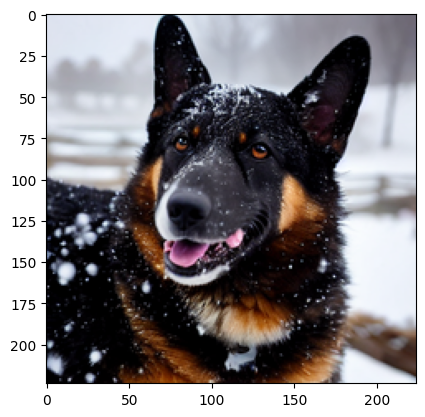

In [ ]:
# Check that images were loaded correctly
plt.imshow(data_list_no_transforms[15][0])